# new model solo hr e label

In [1]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import pandas as pd
from numpy.random import default_rng
from scipy import stats
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import extract_correct_csv


print(f'PyMC version {pm.__version__}')

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


PyMC version 4.2.2


In [2]:
RANDOM_SEED = 31415
rng = default_rng(RANDOM_SEED)

# keep only generalization trials
num_trials_to_remove = 48

# functions that creates triangular matrices
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="aesara"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"aesara", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "aesara":
            return at.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = at.zeros((d, k), dtype=float) if mtype == "aesara" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out


def makeW(d, k, dim_names, name):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z_" + name, 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b_" + name, 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, at.ones(k))
    W = pm.Deterministic(name, at.dot(L, at.diag(at.extra_ops.cumsum(z))), dims=dim_names)
    return W



In [3]:
sub = 43
k = 2

# hr data
hr = pd.read_csv('data/features_4_2/eda/' + str(sub) + '.csv')
hr = hr[num_trials_to_remove:]

# pain expectation data
string_sub = extract_correct_csv.read_correct_subject_csv(sub)
df_ = pd.read_csv('data/LookAtMe_0' + string_sub + '.csv', sep='\t')
df_ = df_[num_trials_to_remove:]
label = np.array(list([int(d > 2) for d in df_['rating']]))
E = label[:, np.newaxis]
E = pd.DataFrame(E)

# num trials
N = hr.shape[0]

TRAIN_PERC = 0.70
VAL_PERC = 0.1
TEST_PERC = 0.2  # 1-TRAIN_PERC+VAL_PERC
N_train = int(N * TRAIN_PERC)
N_val = int(N * VAL_PERC)

# RANDOM SPLIT

hr = hr.sample(frac=1, random_state=0)
hr = hr.reset_index(drop=True).to_numpy()

e_labels = E.sample(frac=1, random_state=0)
e_labels = e_labels.reset_index(drop=True).to_numpy()

hr_train = hr[:N_train]
e_labels_train = e_labels[:N_train]

hr_val = hr[N_train:N_train + N_val]
e_labels_val = e_labels[N_train:N_train + N_val]

hr_test = hr[N_train + N_val:]
e_labels_test = e_labels[N_train + N_val:]

# dimensions of each signal
d_hr = hr_train.shape[1]
d_e = e_labels_train.shape[1]

In [4]:
# model definition
with pm.Model() as PPCA_identified:
    # model coordinates
    PPCA_identified.add_coord("latent_columns", np.arange(k), mutable=True)
    PPCA_identified.add_coord("rows", np.arange(N_train), mutable=True)
    PPCA_identified.add_coord("observed_hr", np.arange(d_hr), mutable=False)
    PPCA_identified.add_coord("observed_label", np.arange(d_e), mutable=False)

    hr_data = pm.MutableData("hr_data", hr_train.T, dims=["observed_hr", "rows"])

    W_hr = makeW(d_hr, k, ("observed_hr", "latent_columns"), 'W_hr')

    W_e = pm.Normal("W_e", dims=["observed_label", "latent_columns"])
    C = pm.Normal("C", dims=["latent_columns", "rows"])

    psi_hr = pm.HalfNormal("psi_hr", 1.0)
    X_hr = pm.Normal("X_hr", mu=at.dot(W_hr, C), sigma=psi_hr, observed=hr_data, dims=["observed_hr", "rows"])

    X_e = pm.Bernoulli("X_e", p=pm.math.sigmoid(at.dot(W_e, C)), dims=["observed_label", "rows"],
                       observed=e_labels_train.T)

In [5]:
gv = pm.model_to_graphviz(PPCA_identified)
gv.view('PPCA definitive')

'PPCA definitive.pdf'

In [6]:
with PPCA_identified:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(1000)

qt5ct: using qt5ct plugin
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/32/"
Invalid Context= "Apps" line

Finished [100%]: Average Loss = 6,715.3


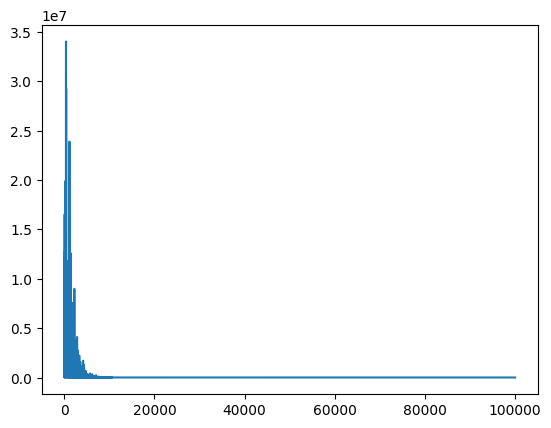

In [7]:
plt.plot(approx.hist)

In [8]:
with PPCA_identified:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, var_names=["X_e"], random_seed=123)

e_pred_train = posterior_predictive.posterior_predictive['X_e']
e_pred_mode_train = np.squeeze(stats.mode(e_pred_train[0], keepdims=False)[0])[:, np.newaxis]

Sampling: [X_e]


In [9]:
train_accuracy = accuracy_score(e_pred_mode_train, e_labels_train)
train_accuracy

0.6282051282051282

In [10]:
C = trace.posterior['C'][0].to_numpy()
C.mean(axis=0).shape

(2, 78)

In [11]:
'''def my_post_predict(trace,hr_val):
    whr_ = trace.posterior['W_hr'][0].to_numpy().mean(axis=0)
    we_ = trace.posterior['W_e'][0].to_numpy().mean(axis=0)
    C_val = np.matmul(np.linalg.pinv(whr_),hr_val.T)
    val_label_gen = np.dot(we_,C_val)
    res = np.where(val_label_gen<0,0,1)
    return res.T'''

"def my_post_predict(trace,hr_val):\n    whr_ = trace.posterior['W_hr'][0].to_numpy().mean(axis=0)\n    we_ = trace.posterior['W_e'][0].to_numpy().mean(axis=0)\n    C_val = np.matmul(np.linalg.pinv(whr_),hr_val.T)\n    val_label_gen = np.dot(we_,C_val)\n    res = np.where(val_label_gen<0,0,1)\n    return res.T"

In [12]:
def my_post_predict(trace,hr_val):
    whr_ = trace.posterior['W_hr'][0]
    C_val = at.dot(np.linalg.pinv(whr_), hr_val.T)
    we_ = trace.posterior['W_e'][0]
    val_label_gen = at.matmul(np.array(we_),C_val.eval())
    label_val = np.where(val_label_gen.eval()<0, 0, 1)
    label_val = stats.mode(label_val[0], keepdims=False)[0]
    return  label_val

In [13]:
validation_accuracy_exp = accuracy_score(e_labels_val, my_post_predict(trace,hr_val))
validation_accuracy_exp

0.18181818181818182

In [14]:
test_accuracy_exp = accuracy_score(e_labels_test, my_post_predict(trace, hr_test))
test_accuracy_exp

0.43478260869565216